# Testing 10 images here with Focal Loss

This notebook is to show how to we do image inference with our Focal Loss with its best weights.

# Initialization



## install and include
First we will install some dependencies first.

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-of78ryna
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-of78ryna
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267008 sha256=262c046f2078bcde1a3c987235af1edca3de6cab815f02f2c57a83a777148d5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-kk1vs9g6/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free

install detectron2, which is from facebook group

In [2]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import os

## Download and register the dataset

Register the face and face_mask dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. 

In [4]:
!wget https://cloud.tsinghua.edu.cn/f/fa57e933bdf54291acf4/?dl=1 -O test_image.zip

--2020-06-14 14:09:31--  https://cloud.tsinghua.edu.cn/f/fa57e933bdf54291acf4/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.8.7
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/38103638-fa30-444f-b300-eafac56ffd58/images.zip [following]
--2020-06-14 14:09:32--  https://cloud.tsinghua.edu.cn/seafhttp/files/38103638-fa30-444f-b300-eafac56ffd58/images.zip
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 857069 (837K) [application/zip]
Saving to: ‘test_image.zip’

test_image.zip      100%[===================>] 836.98K   834KB/s    in 1.0s    

2020-06-14 14:09:33 (834 KB/s) - ‘test_image.zip’ saved [857069/857069]



In [5]:
!unzip test_image.zip > /dev/null
os.remove("test_image.zip")

replace images/19_Couple_Couple_19_86.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_facemask_dict(img_dir,jsonName):
  json_file = os.path.join(img_dir, jsonName)
  with open(json_file) as f:
    imgs_anns = json.load(f)

  dataset_dicts = []
  for idx, v in enumerate(imgs_anns['images']):
    record = {}
    filename = os.path.join(img_dir, v['id'])
    height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width
    objs = []
    for _, annos in enumerate(imgs_anns['annotations']):
      if annos['image_id'] == v['id']:
        data = annos['bbox']
        obj = {
        "bbox": data,
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": annos['segmentation'],
        "category_id": annos['category_id']-1,
        }
        objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)
      
  return dataset_dicts

Regitster the datasets to catalog according to if its for training or validation purpose.

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog._REGISTERED.clear()
d = "val"
DatasetCatalog.register("face_mask_" + d, lambda d=d: get_facemask_dict("images", "test-images.json"))
MetadataCatalog.get("face_mask_" + d).set(thing_classes=["face","face_mask"])
face_mask_metadata = MetadataCatalog.get("face_mask_train")

In [0]:
# dataset_dicts = get_balloon_dicts("balloon/train")
test_dicts = get_facemask_dict("images","test-images.json")

## Import model

We have pretrained one final model's weight with 10000 iterations, let's download it for use.

In [0]:
# Create target directory & all intermediate directories if don't exists
dirName = "model"
os.makedirs(dirName, exist_ok=True) 


In [10]:
cfg = get_cfg()
!wget "https://cloud.tsinghua.edu.cn/f/817b9559279b4756880b/?dl=1" -O model/retinanet_weights_final.pth

--2020-06-14 14:09:46--  https://cloud.tsinghua.edu.cn/f/817b9559279b4756880b/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.8.7
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/d80f8f5d-258e-4ca0-ae71-41b706aeb841/focal_loss_final.pth [following]
--2020-06-14 14:09:47--  https://cloud.tsinghua.edu.cn/seafhttp/files/d80f8f5d-258e-4ca0-ae71-41b706aeb841/focal_loss_final.pth
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 289998897 (277M) [application/octet-stream]
Saving to: ‘model/retinanet_weights_final.pth’

model/retinanet_wei 100%[===================>] 276.56M  17.7MB/s    in 17s     

2020-06-14 14:10:05 (16.1 MB/s) - ‘model/retinanet_weights_final.pth’ saved [289998897/289998897]



Some initializations:

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.MODEL.WEIGHTS = 'model/retinanet_weights_final.pth'
cfg.MODEL.RETINANET.FOCAL_LOSS_GAMMA = 2.0
cfg.MODEL.RETINANET.FOCAL_LOSS_ALPHA = 0.25
# cfg.merge_from_file("./detectron2_repo/configs/COCO-Detection/retinanet_R_50_FPN_1x.yaml")
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.RETINANET.NUM_CLASSES = 2
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model

predictor = DefaultPredictor(cfg)

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


# Start testing!

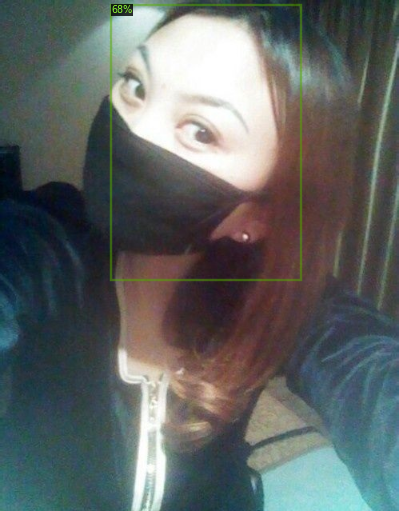

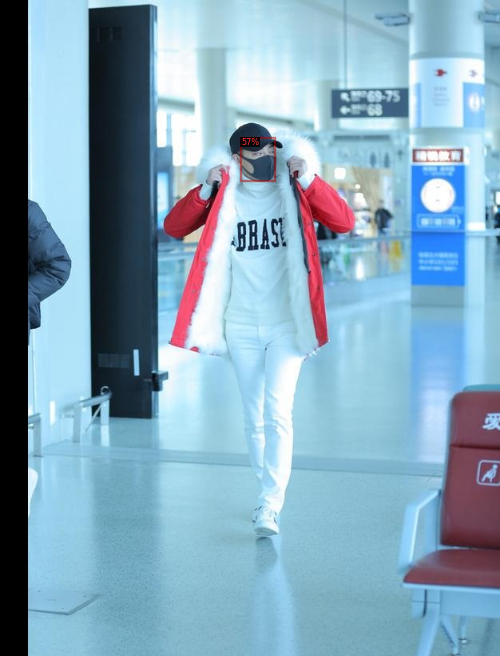

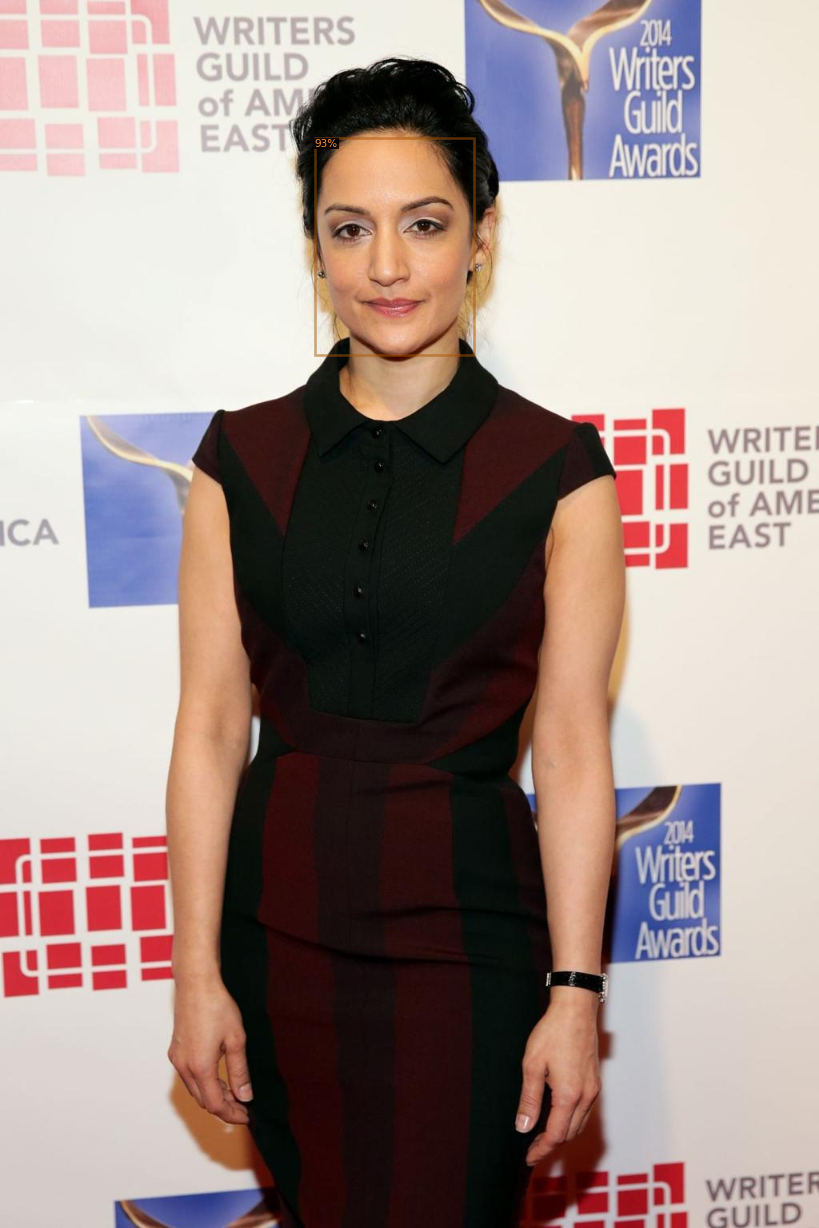

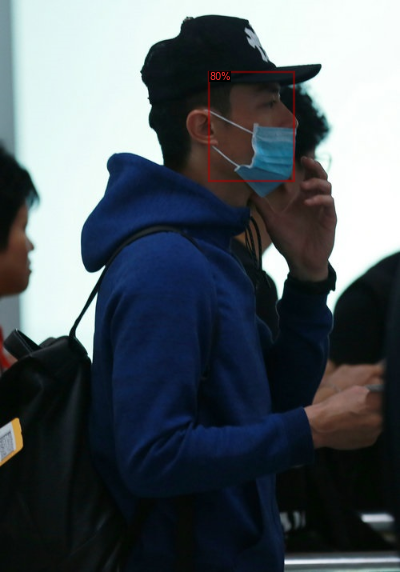

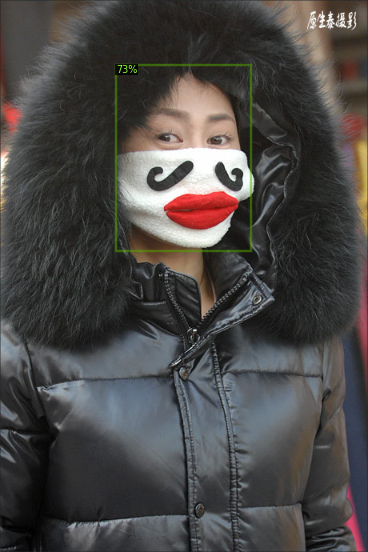

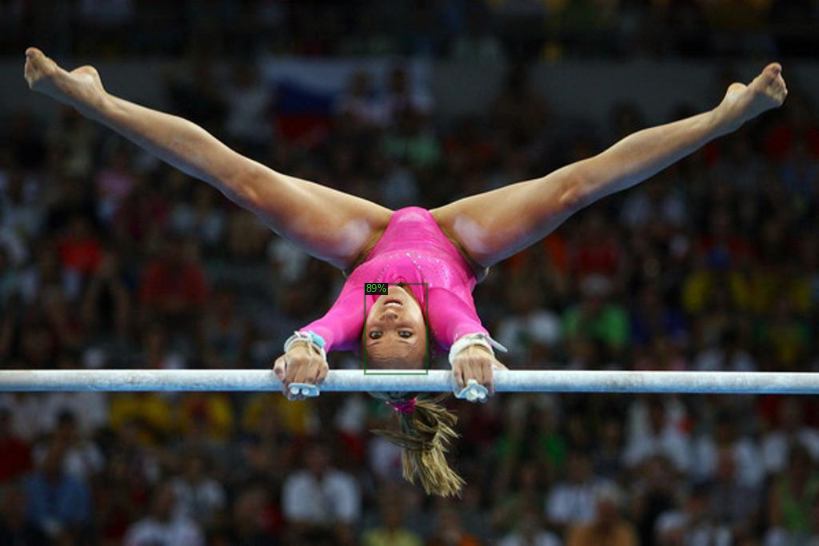

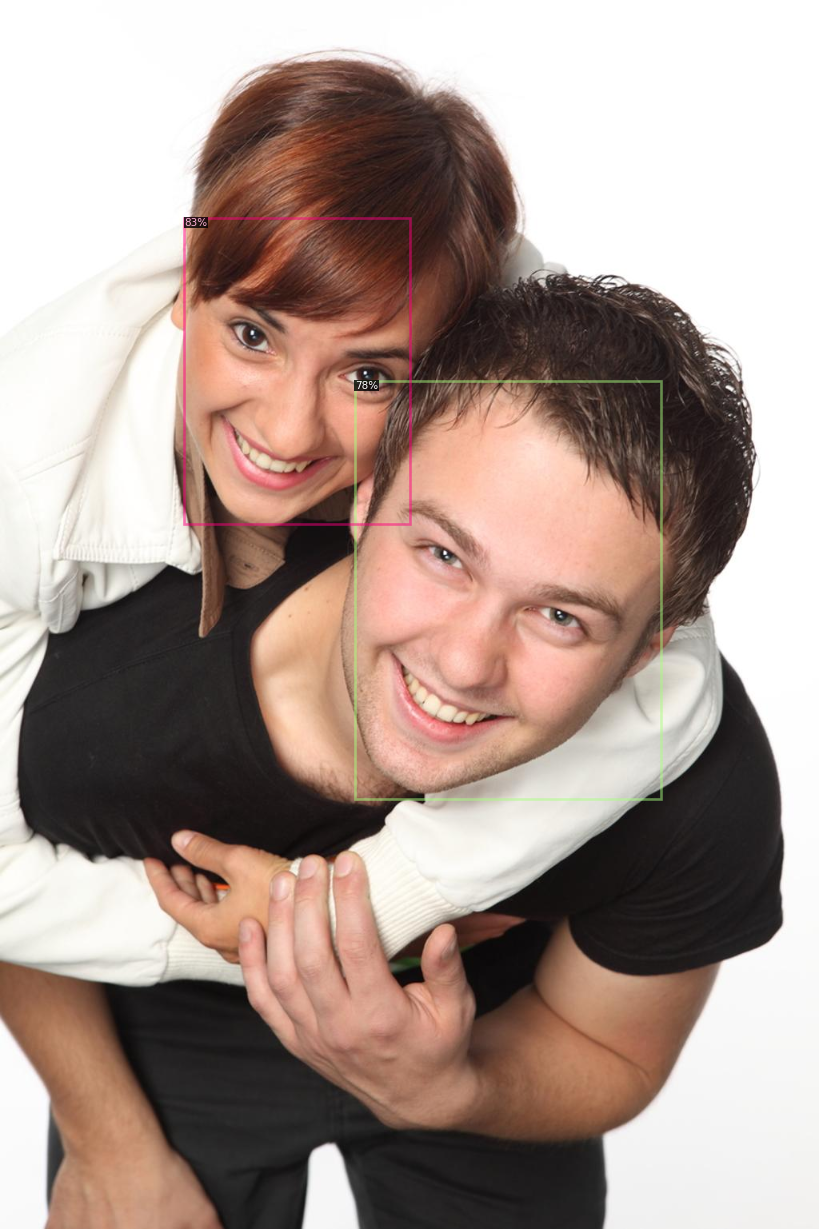

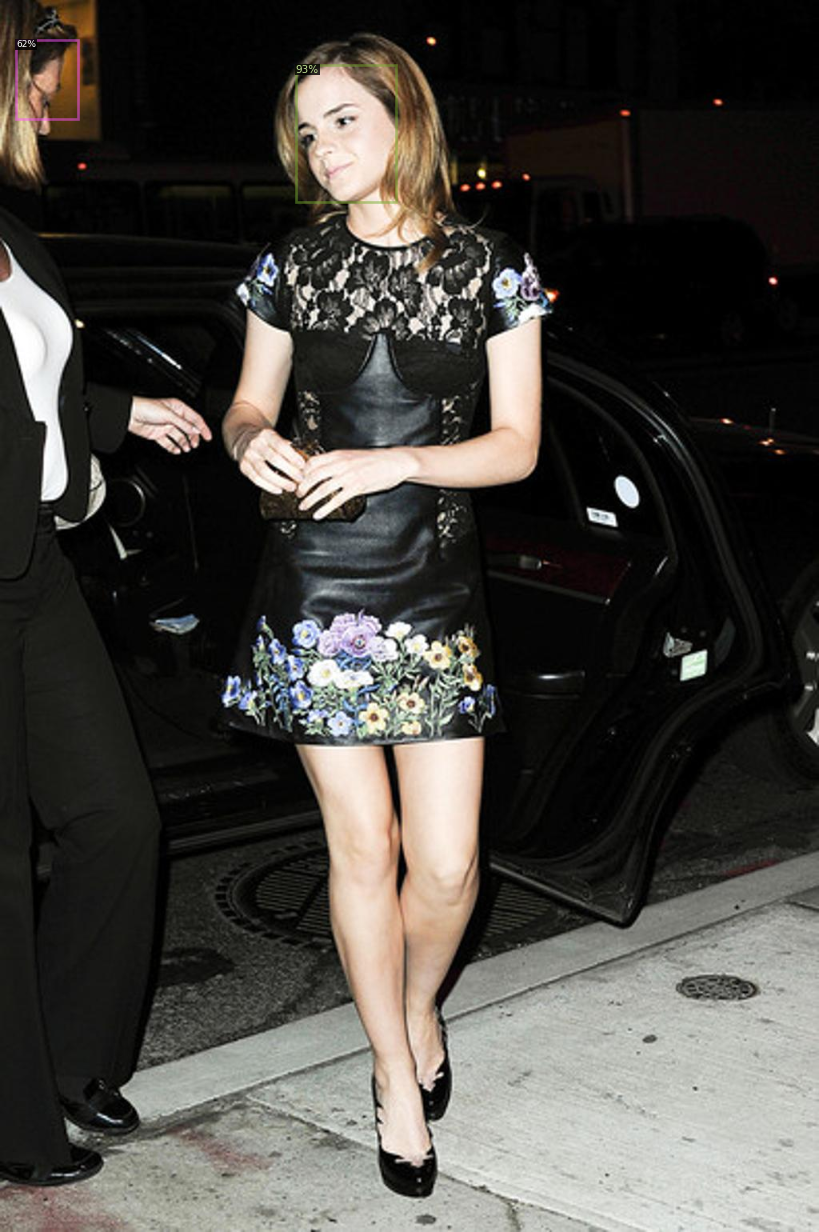

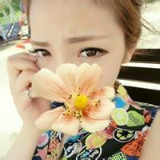

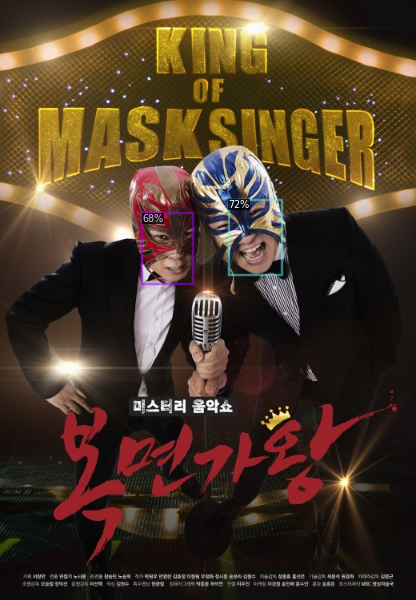

In [12]:
for d in test_dicts:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=face_mask_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API. 

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer
evaluator = COCOEvaluator("face_mask_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "face_mask_val")
inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [06/14 14:10:13 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'face_mask_val'. Trying to convert it to COCO format ...
WARNING [06/14 14:10:13 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/face_mask_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[06/14 14:10:13 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    face    | 10           | face_mask  | 4            |
|            |              |            |              |
|   total    | 14           |            |              |
[06/14 14:10:13 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[06/14 14:10:13 d2.data.common]: Serialized dataset takes 0.00 MiB
[06/14 14:10:13 d2.evaluation.evaluator]: Start inference on 10 images
[06/14 14:10:15 

OrderedDict([('bbox',
              {'AP': 44.133663366336634,
               'AP-face': 47.277227722772274,
               'AP-face_mask': 40.99009900990099,
               'AP50': 84.65346534653465,
               'AP75': 42.07920792079208,
               'APl': nan,
               'APm': nan,
               'APs': 48.31683168316832})])